# Day 16: Decisions Under Uncertainty, Continued

---

- Broad decision strategies *under uncertainty*
  - Robust design (reduce variability)
  - Reliable design (control failure rates)
  - Nothing stopping you from combining the two!
- Decision examples
  1. Reliable beam
  2. Available Pareto frontier
  3. Competing products


In [3]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


## DUU Strategies

---

DUU = decision under uncertainty


## Robust Design

*Philosphy*: Minimize variation, because we can easily fix an offset.


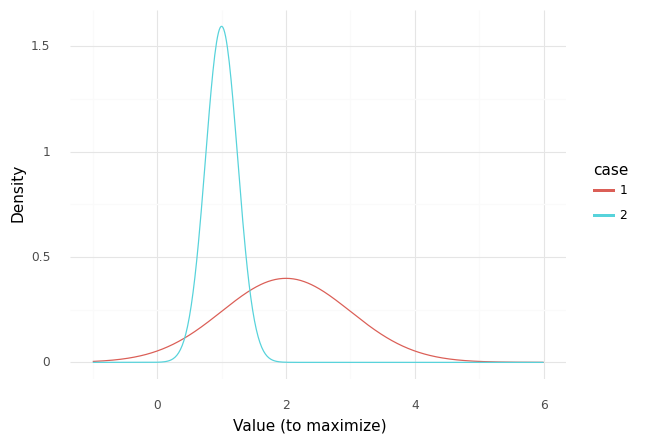

<ggplot: (8730409391981)>

In [22]:
(
    gr.df_make(x=np.linspace(-1, +6, num=500))
    >> gr.tf_mutate(
        l_1=gr.exp(-0.5 * (DF.x - 2)**2) / np.sqrt(2 * np.pi),
        l_2=gr.exp(-0.5 * ((DF.x - 1) / (1/4))**2) / np.sqrt(2 * 1/16 * np.pi),
    )
    >> gr.tf_gather("key", "l", ["l_1", "l_2"])
    >> gr.tf_mutate(case=gr.str_extract(DF.key, "\\d"))
    
    >> ggplot(aes("x", "l", color="case"))
    + geom_line()
    
    + theme_minimal()
    + labs(x="Value (to maximize)", y="Density")
)

A formal robust design optimization program is:

$$\min\, \mathbb{E}[f(d, X)], \mathbb{SD}[f(d, X)]$$
$$\text{wrt.}\, d$$

Note, this is a multi-objective optimization over the mean and standard deviation! (There's a *reason* we learned all this stuff!)


## Reliable Design

*Philosphy*: Constrain the probability of unacceptable failure modes.


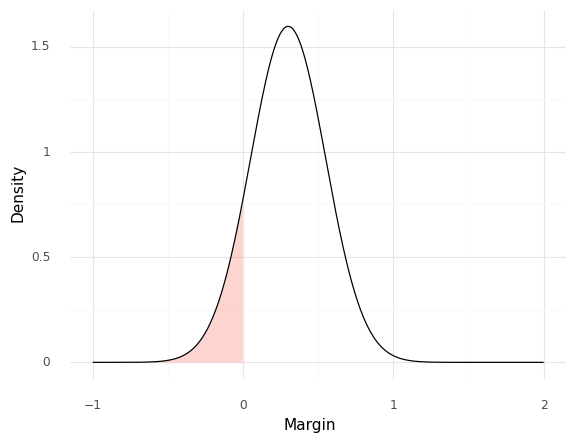

<ggplot: (8730409192391)>

In [30]:
df_tmp = (
    gr.df_make(x=np.linspace(-1, +2, num=500))
    >> gr.tf_mutate(
        l=gr.exp(-0.5 * ((DF.x - 0.3) / (1/4))**2) / np.sqrt(2 * 1/16 * np.pi),
    )
)

(
    df_tmp
    >> ggplot(aes("x", "l"))
    + geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(DF.x <= 0),
        mapping=aes(ymin=0, ymax="l"),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line()
    
    + theme_minimal()
    + labs(x="Margin", y="Density")
)


A formal reliable design optimization program is:

$$\min\, f(d)$$
$$\text{wrt.}\, d$$
$$\text{s.t.}\, \mathbb{P}[g(d, X) \leq 0] \leq \mathcal{F}$$

Note that our objective needs to be deterministic; it could be the mean of some random performance. We could also write the constraint in terms of words:

$$\text{s.t.}\, \mathbb{P}[\text{Catastrophic failure}] \leq \text{Acceptable Failure Rate}$$



## Which philosophy to apply?

For both of the use-cases, which philosophy seems most appropriate: robust or reliable design?

> Use-case A: Load-bearing member in a building

> Use-case B: Standoff on an optics table

<br>
<br>
<br>

> Use-case A: Load-bearing member in a building
> - Structural members of a building have high-consequence failure modes; reliability design makes the most sense to me

> Use-case B: Standoff on an optics table
> - Optics applications require extremely tight tolerances; robust design makes the most sense to me


## Using both philosophies!

There's nothing stopping us from applying both Robust and Reliable ideas at once. This might be *necessary* if uncertainties affect our objective(s) and constraints:

$$\min\, \mathbb{E}[f(d, X)], \mathbb{SD}[f(d, X)]$$
$$\text{wrt.}\, d$$
$$\text{s.t.} \mathbb{P}[g(d, X) \leq 0] \leq \mathcal{F}$$


### Design Under Uncertainty, closing notes

I write about Design Under Uncertainty in Section 2.4 of my PhD thesis.


## Decision Examples

---


### 1. Reliable beam


In [2]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      t: [2, 4]
      w: [2, 4]

    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']



Scenario:

We have a proposed design $w = 3, t = 3$, a desired failure rate $\mathbb{P}[Failure] \leq 0.01$, and the following quantitative assessment:


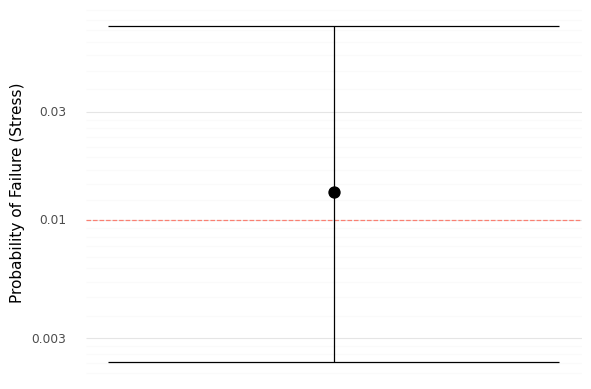

<ggplot: (8744009001226)>

In [14]:
df_design = gr.df_make(w=3.0, t=3.0)

(
    md_beam
    >> gr.ev_monte_carlo(
        df_det=df_design,
        n=75,
        seed=101,
    )
    >> gr.tf_summarize(
        pof_stress_lo=gr.binomial_ci(DF.g_stress <= 0, side="lo"),
        pof_stress_mu=gr.mean(DF.g_stress <= 0),
        pof_stress_up=gr.binomial_ci(DF.g_stress <= 0, side="up"),
    )
    
    >> ggplot(aes(x=0))
    + geom_hline(yintercept=1e-2, color="salmon", linetype="dashed")
    + geom_errorbar(aes(ymin="pof_stress_lo", ymax="pof_stress_up"))
    + geom_point(aes(y="pof_stress_mu"), size=4)
    
    + scale_x_continuous(breaks=())
    + scale_y_log10()
    + theme_minimal()
    + labs(
        x="",
        y="Probability of Failure (Stress)"
    )
)

*Questions*:
- What sources of uncertainty do you have?
  - Are they aleatory or epistemic? 
- Does this design meet the requirements?
- Which source of uncertainty is *blocking* your progress?
- What does this suggest about your next move?
  
<br>
<br>
<br>

- What sources of uncertainty do you have?
  - Inherent variability: aleatory
  - Limitations of monte carlo sample size: epistemic
  - Limitations of material model: epistemic
- Does this design meet the requirements?
  - Unknown; The CI suggests the true failure rate could meet or violate the constraint
- Which source of uncertainty is *blocking* your progress?
  - The uncertainty due to monte carlo sample size is blocking our progress
- What does this suggest about your next move?
  - The limitations of our monte carlo prevent us from concluding whether the design meets our requirements; a simple first-step would be to increase the sample size $n$. This move is suggested because 


**Punchline**: A valid response to epistemic uncertainty is to seek more information


### 2. Available Pareto frontier

Imagine we're designing a widget for a high-volume production. We have a target for variability (standard deviation) in performance, but we've seen that there's a tradeoff in performance and cost.

Right now, we're using fairly cheap materials to produce the widgets; we could potentially cut the standard deviation by $1/4$ for a $2\times$ unit cost.


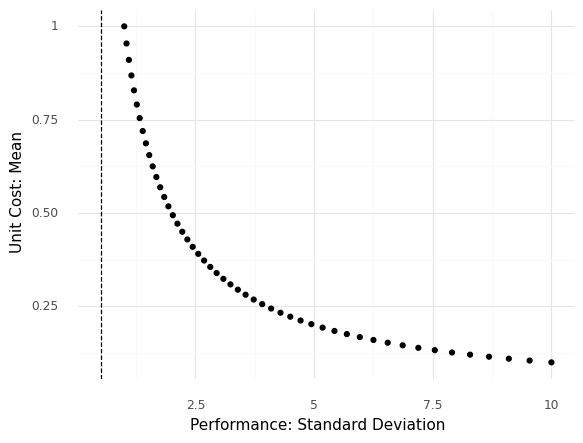

<ggplot: (8744009692733)>

In [52]:
(
    ## Some fake data
    gr.df_make(sd=np.logspace(+0, +1))
    >> gr.tf_mutate(mean=1 / DF.sd)
    
    ## Visualize
    >> ggplot(aes("sd", "mean"))
    + geom_vline(xintercept=0.5, linetype="dashed")
    + geom_point()
    
    + theme_minimal()
    + labs(
        x="Performance: Standard Deviation",
        y="Unit Cost: Mean",
    )
)

*Questions*:
- What sources of uncertainty do you have?
  - Are they aleatory or epistemic? 
- Can you meet the standard deviation target with the available designs?
- Which source of uncertainty is challenges this comparison?
- What does this suggest about your next move?
  
<br>
<br>
<br>

- What sources of uncertainty do you have?
  - Variation in the performance measure: aleatory
  - Unperformed analysis: epistemic
- Can you meet the standard deviation target with the available designs?
  - No; it does not appear that any design on this Pareto frontier meets our criteria
  - However, the use of higher-quality material is not visualized here
- Which source of uncertainty is challenges this comparison?
  - We know that we could be using a different material, but we haven't bothered to carry out that analysis. We should analyze those designs and plot them in the same fashion
- What does this suggest about your next move?
  - We should investigate designs using the other material


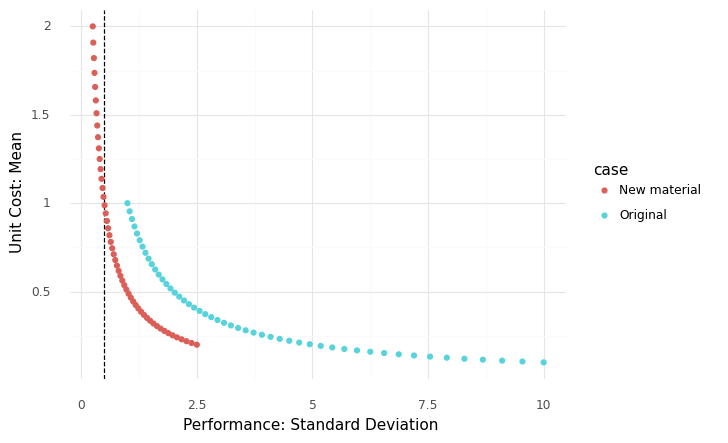

<ggplot: (8744008757568)>

In [51]:
df_tmp = (
    ## Some fake data
    gr.df_make(sd=np.logspace(+0, +1))
    >> gr.tf_mutate(mu=1 / DF.sd)
)

(
    df_tmp
    >> gr.tf_mutate(case="Original")
    >> gr.tf_bind_rows(
        df_tmp
        >> gr.tf_mutate(
            mu=DF.mu * 2,
            sd=DF.sd / 4,
            case="New material"
        )
    )
    
    ## Visualize
    >> ggplot(aes("sd", "mu", color="case"))
    + geom_vline(xintercept=0.5, linetype="dashed")
    + geom_point()
    
    + theme_minimal()
    + labs(
        x="Performance: Standard Deviation",
        y="Unit Cost: Mean",
    )
)

**Punchline**: Carry out an explicit comparison between all cases!


### 3. Competing products

Suppose we're in the business of manufacturing widgets, and we want to produce the highest-performing widgets in large quantities. The widgets have a few manufacturing tolerances, which together give rise to variability in the widget performance. We're comparing a proposed new design against a competitor's design, in terms of its marketed performance.


eval_monte_carlo() is rounding n...


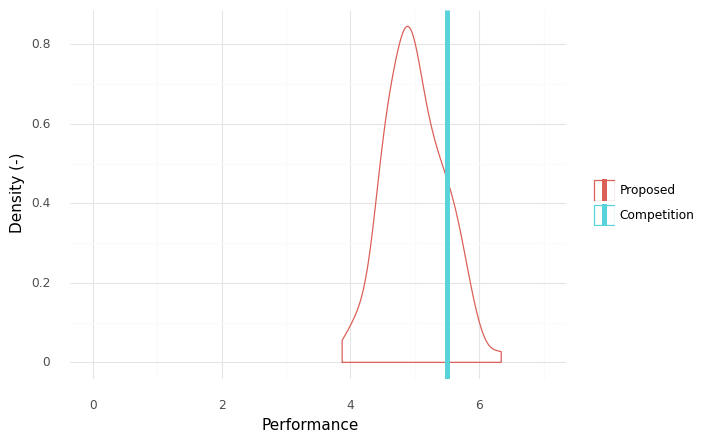

<ggplot: (8744009686917)>

In [27]:
(
    gr.Model("Manufactured part")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(f=df.a + df.b - df.c + 5),
        var=["a", "b", "c"],
        out=["f"],
    )
    >> gr.cp_marginals(
        a=dict(dist="uniform", loc=-0.5, scale=+1.0),
        b=dict(dist="uniform", loc=-0.5, scale=+1.0),
        c=dict(dist="uniform", loc=-0.5, scale=+1.0),
    )
    >> gr.cp_copula_independence()
    
    >> gr.ev_monte_carlo(n=1e2, df_det="nom", seed=101)
    >> gr.tf_mutate(source="Proposed")
    
    >> ggplot(aes("f", color="source"))
    + geom_density()
    + geom_vline(
        data=gr.df_make(f=5.5, source="Competition"),
        mapping=aes(xintercept="f", color="source"),
        size=2,
    )
    
    + scale_color_discrete(name=" ")
    + coord_cartesian(xlim=(0, 7))
    + theme_minimal()
    + labs(
        x="Performance",
        y="Density (-)"
    )
)

*Questions*:
- What sources of uncertainty do you have?
  - Are they aleatory or epistemic? 
- Does the `Proposed` design outperform the `Competition`?
- Which source of uncertainty challenges this comparison?
- What does this suggest about your next move?
  
<br>
<br>
<br>

- What sources of uncertainty do you have?
  - Inherent variability of widget dimensions within-tolerances: aleatory
  - Variability of competing design: epistemic
- Does the `Proposed` design outperform the `Competition`?
  - Unclear
- Which source of uncertainty challenges this comparison?
  - The `Proposed` design is variable, so some widgets will outperform (maybe 25%), and some will fall short
  - Additionally, it's unclear what the variability is in the `Competition` design, which complicates comparison
- What does this suggest about your next move?
  - We could take only those components with Performance above $5.5$ and have a $25\%$ yield in manufacturing
  - Alternatively we could redesign the widget and / or the manufacturing process to reduce variability and bump up mean performance.
  - By obtaining multiple widgets from the `Competition`, we could estimate the variability in the parts they're selling. This would aid in comparison.


**Punchlines**: 
- Some of the most significant uncertainty will **not** be visualized / reported!
- There are **several** ways to respond to variability:
  - Treat yield as a design variable: Use inspection to select parts that perform well
  - Treat manufacturing as a design variable: Redesign the manufacturing process to reduce variability
  - Use existing design variables to modify variability: Design for quality from the beginning (e.g. DFM)


# References

---

- del Rosario "Precision Margin: First-Principles Margins for Aircraft Design Under Uncertainty" (2020) [PhD thesis](https://purl.stanford.edu/xy114jv5352)
- Der Kiureghian and Ditlevsen, "Aleatory or epistemic? Does it matter?" (2009) [link](https://www.sciencedirect.com/science/article/pii/S0167473008000556?casa_token=wMqEeSrOI-EAAAAA:SvXSdoTgMbaRnYfJ6kSIXOW1Ahs1G7xzIv1BUIvuxuQA-cmRo9E-c15FelBcebHrHNghO7le)
